# Wavelet Features Deep Dive (All Datasets)

This notebook performs a focused *deep dive* analysis on **Wavelet features** for
the binary classification problem.  The goal is to test each of :

- **HGLG vs MGLG**: Human-generated, Llama-graded vs Mixtral-generated, Llama-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **HGMG vs LGMG**: Human-generated, Mixtral-graded vs LLaMA-generated, Mixtral-graded (Reuters-50/50 subset)
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral
- **MAGE-LG**: Mixtral-graded MAGE dataset, scored by Llama
- **MAGE-MG**: Mixtral-graded MAGE dataset, scored by Mixtral


### Wavelet (multi-scale energy and shape)
*(computed per wavelet family; names are prefixed, e.g., `db4_*`, `sym4_*`, `coif1_*`, `bior3.3_*`)*
**Notes on coefficients:**
- When you apply a discrete wavelet transform (DWT) to a signal, it splits the signal into two parts at each level:
  - Approximation coefficients (cA) — the low-frequency, slowly varying part (a coarse version of the signal).
  - Detail coefficients (cD) — the high-frequency fluctuations removed at that scale.
- Each level has its own cD array of detail coefficients.

- **{wav}_wavelet_hf_ratio**  
  High-frequency energy ratio: sum(detail energies) / (approx energy + sum(detail energies)).  
  *Why:* global measure of “burstiness” across detail bands; higher = more rapid local variation.

**Notes on detail levels:**
- Detail levels correspond to scales or frequency bands in the wavelet decomposition.
  - detailL1 is the highest-frequency fluctuations (shortest timescale)
  - detailL2 is on a lower frequency range and on a timescale that is twice as long as L1
  - detailL3 is on a lower frequency range still and on a timescale that is 4x as long as L1
- Detail energies show how much energy exists at each timescale of variation.

- **{wav}_detailL{i}_ratio** (i = 1…L)  
  Energy of detail level i divided by total energy. (i=1 >> highest frequencies; larger i = lower frequencies.)  
  *Why:* localizes where (which temporal scale) the energy concentrates; can reveal characteristic fluctuation scales.

- **{wav}_detail_entropy**  
  Shannon entropy of concatenated detail coefficients (via a normalized histogram).  
  *Why:* higher entropy suggests a more “disordered” distribution of wavelet details; lower entropy suggests concentrated/structured bursts.

- **{wav}_detail_kurt** (excess kurtosis)  
  *How:* Perform standard kurtosis formula on concatenated detail coefficients.  
  *Why:* large positive values indicate heavy tails / outliers in detail coefficients (rare, strong bursts).

> **More Wavelet Notes:**  
> - Different wavelet families (Daubechies/Symlets/Coiflets/Biorthogonal) emphasize sharpness vs smoothness differently; comparing families helps find robust signals.

In [34]:
import os, glob
import numpy as np
import pandas as pd
from typing import Iterable

import pywt
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

#   Llama-graded
HUMAN_REUTERS_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
LLM_REUTERS_LLAMA_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_REUTERS_MIXTRAL_LLAMA      = 'data/tokens/bigmixtral-llama70Bw4a16-graded/reuter5050/C50train_clean'
HUMAN_HC3_LLAMA    = 'data/tokens/hc3/human_llama-graded'
LLM_HC3_LLAMA      = 'data/tokens/hc3/chatgpt_llama-graded'
HUMAN_MAGE_LLAMA    = 'data/tokens/mage/human_llama-graded'
LLM_MAGE_LLAMA      = 'data/tokens/mage/llm_llama-graded'

#   Mixtral-graded
HUMAN_REUTERS_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_REUTERS_LLAMA_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'
HUMAN_HC3_MIXTRAL    = 'data/tokens/hc3/human_mixtral-graded'
LLM_HC3_MIXTRAL      = 'data/tokens/hc3/chatgpt_mixtral-graded'
HUMAN_MAGE_MIXTRAL    = 'data/tokens/mage/human_mixtral-graded'
LLM_MAGE_MIXTRAL      = 'data/tokens/mage/llm_mixtral-graded'

RNG = np.random.default_rng(42)


## Data Loading Helpers

In [73]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        series.append(probs)
    return series


## Wavelet Features

We decompose the log-prob sequence with multiple wavelet families and levels,
and compute:
- high-frequency / total energy ratio
- per-level detail energy ratios
- entropy and kurtosis of concatenated detail coefficients

In [74]:
def wavelet_decomp_features(
    x: np.ndarray,
    wavelet_name: str,
    max_levels: int = 5,
) -> dict[str, float]:
    feats: dict[str, float] = {}

    x = np.asarray(x, dtype=np.float64)
    x = x - x.mean()

    try:
        w = pywt.Wavelet(wavelet_name)
    except Exception as err:
        print(f"ERROR MAKING WAVELETS : {err}")
        return feats

    level_cap = pywt.dwt_max_level(len(x), w.dec_len)
    level = min(max_levels, max(1, level_cap))

    coeffs = pywt.wavedec(x, wavelet=w, level=level, mode='symmetric')
    approx = coeffs[0]
    details = coeffs[1:]

    energies = [np.sum(c*c) for c in coeffs]
    e_total = np.sum(energies)
    if e_total <= 0:
        return feats

    e_details = [np.sum(d*d) for d in details]
    e_high = np.sum(e_details)
    feats[f'{wavelet_name}_wavelet_hf_ratio'] = float(e_high / e_total)

    for i, e in enumerate(e_details, start=1):
        feats[f'{wavelet_name}_detailL{i}_ratio'] = float(e / e_total)

    all_detail = np.concatenate(details) if len(details) > 0 else np.array([], dtype=np.float64)
    if all_detail.size > 0:
        hist, edges = np.histogram(all_detail, bins=64, density=True)
        p = hist / (hist.sum() + 1e-12)
        ent = -np.sum(p * np.log(p + 1e-12))
        feats[f'{wavelet_name}_detail_entropy'] = float(ent)

        m2 = np.mean((all_detail - all_detail.mean())**2)
        m4 = np.mean((all_detail - all_detail.mean())**4)
        kurt_excess = m4 / (m2**2 + 1e-12) - 3.0 if m2 > 1e-12 else 0.0
        feats[f'{wavelet_name}_detail_kurt'] = float(kurt_excess)

    return feats


# Feature Extractor 

In [75]:
WAVELETS_TO_TRY = ['db2','db4','db8','sym4','coif1','bior3.3']

def extract_features_from_logp(x: np.ndarray) -> dict[str, float]:
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)

    #   Wavelets
    for wname in WAVELETS_TO_TRY:
        wf = wavelet_decomp_features(x, wavelet_name=wname, max_levels=5)
        for k,v in wf.items():
            feats[k] = v
    else:
        feats['wavelet_missing'] = 1.0

    return feats

# <a color="red"><u>REUTERS</u></a>

## Llama-Generated, Mixtral-Graded

## Build Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Mixtral-graded (HGMG) Reuters documents
- LLaMA-generated, Mixtral-graded (LGMG) Reuters documents 


In [ ]:
def build_feature_df(human_root: str, llm_root: str) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, seq in enumerate(human_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, seq in enumerate(llm_series):
        feats = extract_features_from_logp(seq)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)



/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.511403,0.026663,0.024047,0.075881,0.108467,0.276343,3.364480,2.749256,0.510947,0.019944,...,0.057843,0.153301,0.120646,0.072082,3.217565,3.087977,1.0,human,human_0,NaN
1,0.742199,0.035358,0.079799,0.080868,0.182259,0.363915,3.652856,0.840252,0.850646,0.032704,...,0.200239,0.128623,0.167824,0.109167,3.098870,4.232061,1.0,human,human_1,0.396002
2,0.281988,0.023166,0.037156,0.067650,0.154016,NaN,3.557792,-0.057694,0.626366,0.115959,...,0.193049,0.035034,NaN,NaN,2.731437,10.565418,1.0,human,human_2,NaN
3,0.493423,0.031726,0.037955,0.059813,0.103738,0.260191,3.330958,2.210037,0.455050,0.026842,...,0.058526,0.087453,0.065376,0.054077,2.967198,5.179458,1.0,human,human_3,0.259744
4,0.408557,0.026285,0.021712,0.053524,0.103539,0.203497,3.203469,2.986021,0.371610,0.011231,...,0.044034,0.076900,0.042885,0.043977,2.907588,6.884723,1.0,human,human_4,NaN


In [76]:
# Build the core dataframe 
df_mixtral = build_feature_df(HUMAN_REUTERS_MIXTRAL, LLM_REUTERS_LLAMA_MIXTRAL)
df_mixtral.head()

/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.511403,0.026663,0.024047,0.075881,0.108467,0.276343,3.364480,2.749256,0.510947,0.019944,...,0.057843,0.153301,0.120646,0.072082,3.217565,3.087977,1.0,human,human_0,NaN
1,0.742199,0.035358,0.079799,0.080868,0.182259,0.363915,3.652856,0.840252,0.850646,0.032704,...,0.200239,0.128623,0.167824,0.109167,3.098870,4.232061,1.0,human,human_1,0.396002
2,0.281988,0.023166,0.037156,0.067650,0.154016,NaN,3.557792,-0.057694,0.626366,0.115959,...,0.193049,0.035034,NaN,NaN,2.731437,10.565418,1.0,human,human_2,NaN
3,0.493423,0.031726,0.037955,0.059813,0.103738,0.260191,3.330958,2.210037,0.455050,0.026842,...,0.058526,0.087453,0.065376,0.054077,2.967198,5.179458,1.0,human,human_3,0.259744
4,0.408557,0.026285,0.021712,0.053524,0.103539,0.203497,3.203469,2.986021,0.371610,0.011231,...,0.044034,0.076900,0.042885,0.043977,2.907588,6.884723,1.0,human,human_4,NaN


## Train / Validation Split

In [77]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [78]:
from dataclasses import dataclass

@dataclass
class ThresholdResult:
    feature: str
    direction: str
    threshold: float
    degenerate: bool
    train_accuracy: float
    train_precision: float
    train_recall: float
    train_f1_human: float
    train_f1_llm: float
    train_f1_macro: float
    train_auroc: float
    val_accuracy: float
    val_precision: float
    val_recall: float
    val_f1_human: float
    val_f1_llm: float
    val_f1_macro: float
    val_auroc: float

def _eval_threshold(
    y_true: np.ndarray,
    scores: np.ndarray,
    threshold: float,
    direction: str,
) -> tuple[np.ndarray, dict[str,float]]:
    """Apply a single threshold to scores and compute metrics."""
    if direction == '>=':
        y_pred = (scores >= threshold).astype(int)
    else:
        y_pred = (scores <= threshold).astype(int)

    degenerate = (y_pred.min() == y_pred.max())
    metrics = {}
    metrics['degenerate'] = degenerate
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    # F1s per class, then macro
    metrics['f1_human'] = f1_score(y_true, y_pred, pos_label=0, zero_division=0)
    metrics['f1_llm']   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        metrics['auroc'] = roc_auc_score(y_true, scores)
    except Exception:
        metrics['auroc'] = np.nan
    return y_pred, metrics

def threshold_search_for_feature(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature: str,
    positive_label: str = 'llm',
    n_grid: int = 200,
    threshold_metric: str = 'accuracy',
) -> ThresholdResult:
    """Find the best 1D threshold classifier for a given feature.

    The positive class is mapped from `positive_label`. We search over
    `>=` and `<=` directions and a grid of thresholds spanning the feature
    range in the training set.
    """
    # Encode labels as 0/1
    y_train = (train_df['label'] == positive_label).astype(int).values
    y_val   = (val_df['label'] == positive_label).astype(int).values

    x_train = train_df[feature].values.astype(float)
    x_val   = val_df[feature].values.astype(float)

    finite_mask = np.isfinite(x_train)
    x_train = x_train[finite_mask]
    y_train_nonan = y_train[finite_mask]
    if x_train.size == 0:
        return ThresholdResult(
            feature, '>=', np.nan, True,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
            np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
        )

    lo, hi = np.nanmin(x_train), np.nanmax(x_train)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = lo, lo + 1e-6

    grid = np.linspace(lo, hi, n_grid)
    best_res = None
    best_score = -1.0

    for direction in ('>=','<='):
        for t in grid:
            _, m_train = _eval_threshold(y_train_nonan, x_train, t, direction)
            if m_train[threshold_metric] > best_score:
                best_score = m_train[threshold_metric]
                best_res = (t, direction, m_train)

    # Recompute metrics on full train and validation with best threshold
    best_t, best_dir, train_metrics = best_res
    _, train_metrics_full = _eval_threshold(y_train, train_df[feature].values.astype(float), best_t, best_dir)
    _, val_metrics = _eval_threshold(y_val, val_df[feature].values.astype(float), best_t, best_dir)

    return ThresholdResult(
        feature=feature,
        direction=best_dir,
        threshold=float(best_t),
        degenerate=train_metrics_full['degenerate'],
        train_accuracy=train_metrics_full['accuracy'],
        train_precision=train_metrics_full['precision_macro'],
        train_recall=train_metrics_full['recall_macro'],
        train_f1_human=train_metrics_full['f1_human'],
        train_f1_llm=train_metrics_full['f1_llm'],
        train_f1_macro=train_metrics_full['f1_macro'],
        train_auroc=train_metrics_full['auroc'],
        val_accuracy=val_metrics['accuracy'],
        val_precision=val_metrics['precision_macro'],
        val_recall=val_metrics['recall_macro'],
        val_f1_human=val_metrics['f1_human'],
        val_f1_llm=val_metrics['f1_llm'],
        val_f1_macro=val_metrics['f1_macro'],
        val_auroc=val_metrics['auroc'],
    )


## Deep Dive: Threshold Search and Random Forest

We now isolate **entropy features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [79]:
"""
**{wav}_wavelet_hf_ratio**  
**{wav}_detailL{i}_ratio** (i = 1…L)  
**{wav}_detail_entropy**  
**{wav}_detail_kurt** (excess kurtosis)  
"""
hf_ratio_features = [c for c in df_mixtral.columns if c.endswith('hf_ratio')]
detail_ratio_features = [c for c in df_mixtral.columns if ("detail" in c and c.endswith("ratio"))]
detail_entropy_features = [c for c in df_mixtral.columns if c.endswith('detail_entropy')]
detail_kurt_features = [c for c in df_mixtral.columns if c.endswith('detail_kurt')]
print(f"hf_ratio_features {hf_ratio_features}")
print(f"detail_ratio_features {detail_ratio_features}")
print(f"detail_entropy_features {detail_entropy_features}")
print(f"detail_kurt_features {detail_kurt_features}")

hf_ratio_features ['db2_wavelet_hf_ratio', 'db4_wavelet_hf_ratio', 'db8_wavelet_hf_ratio', 'sym4_wavelet_hf_ratio', 'coif1_wavelet_hf_ratio', 'bior3.3_wavelet_hf_ratio']
detail_ratio_features ['db2_detailL1_ratio', 'db2_detailL2_ratio', 'db2_detailL3_ratio', 'db2_detailL4_ratio', 'db2_detailL5_ratio', 'db4_detailL1_ratio', 'db4_detailL2_ratio', 'db4_detailL3_ratio', 'db4_detailL4_ratio', 'db4_detailL5_ratio', 'db8_detailL1_ratio', 'db8_detailL2_ratio', 'db8_detailL3_ratio', 'db8_detailL4_ratio', 'sym4_detailL1_ratio', 'sym4_detailL2_ratio', 'sym4_detailL3_ratio', 'sym4_detailL4_ratio', 'sym4_detailL5_ratio', 'coif1_detailL1_ratio', 'coif1_detailL2_ratio', 'coif1_detailL3_ratio', 'coif1_detailL4_ratio', 'coif1_detailL5_ratio', 'bior3.3_detailL1_ratio', 'bior3.3_detailL2_ratio', 'bior3.3_detailL3_ratio', 'bior3.3_detailL4_ratio', 'bior3.3_detailL5_ratio', 'db8_detailL5_ratio']
detail_entropy_features ['db2_detail_entropy', 'db4_detail_entropy', 'db8_detail_entropy', 'sym4_detail_entropy'

In [80]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

results = []
for feat in hf_ratio_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,db2_wavelet_hf_ratio,>=,0.388395,False,0.732624,0.674308,0.590689,0.353345,0.831471,0.592408,0.609230,0.718130,0.641871,0.571223,0.311419,0.822796,0.567107,0.634126
3,sym4_wavelet_hf_ratio,>=,0.351236,False,0.726950,0.689774,0.552952,0.225352,0.834266,0.529809,0.628154,0.719547,0.671175,0.537971,0.175000,0.831058,0.503029,0.648602
4,coif1_wavelet_hf_ratio,>=,0.323006,False,0.724823,0.726003,0.537096,0.156522,0.835593,0.496057,0.619529,0.720963,0.717727,0.530408,0.132159,0.833755,0.482957,0.639301
2,db8_wavelet_hf_ratio,>=,0.401331,False,0.725532,0.772444,0.533289,0.134228,0.836915,0.485572,0.603062,0.723796,0.772432,0.530981,0.125561,0.835997,0.480779,0.601845
1,db4_wavelet_hf_ratio,>=,0.370043,False,0.724823,0.693916,0.544632,0.193347,0.834117,0.513732,0.551214,0.706799,0.597562,0.516126,0.103896,0.824725,0.464310,0.541223
5,bior3.3_wavelet_hf_ratio,>=,0.196485,False,0.713830,0.856201,0.508526,0.033533,0.832050,0.432791,0.613655,0.709632,0.854610,0.502427,0.009662,0.829876,0.419769,0.623369


Mixtral-graded (HGMG vs LGMG) : Wavelet HF Ratio Random Forest
accuracy (val):        0.759
precision_macro (val): 0.728
recall_macro (val):    0.632
f1_macro (val):        0.644
AUROC (val):           0.752


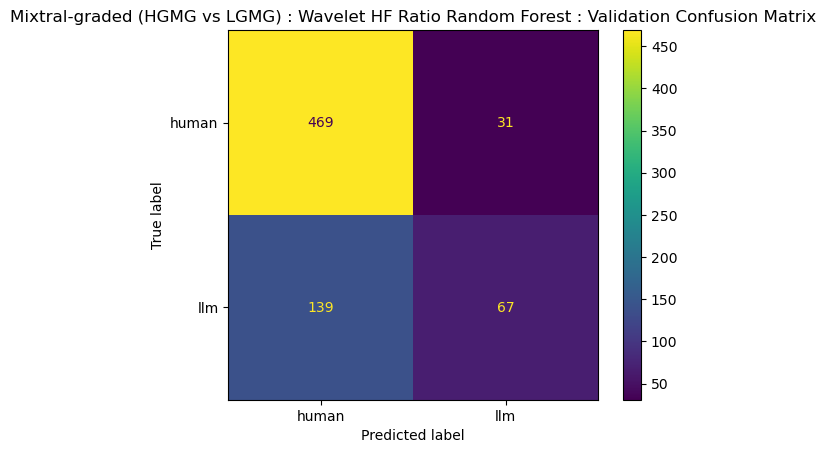

db2_wavelet_hf_ratio        0.189520
bior3.3_wavelet_hf_ratio    0.167742
db8_wavelet_hf_ratio        0.166720
db4_wavelet_hf_ratio        0.162996
coif1_wavelet_hf_ratio      0.157668
sym4_wavelet_hf_ratio       0.155354
dtype: float64

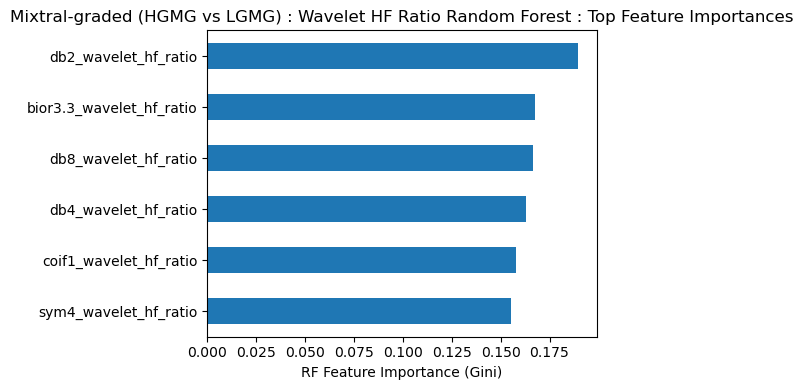

In [81]:
def model_eval_random_forest_subset(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    feature_cols: list[str],
    title: str = "",
):
    # Prepare design matrices
    X_train = train_df[feature_cols].copy().fillna(train_df[feature_cols].mean())
    X_val   = val_df[feature_cols].copy().fillna(train_df[feature_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    auroc = roc_auc_score(y_val, y_val_proba)

    print(f"{title}")
    print("="*len(title))
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'feature_cols': feature_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }

# Run RF on features only
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=hf_ratio_features,
    title='Mixtral-graded (HGMG vs LGMG) : Wavelet HF Ratio Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-graded (HGMG vs LGMG) : All Features Random Forest
accuracy (val):        0.805
precision_macro (val): 0.789
recall_macro (val):    0.708
f1_macro (val):        0.729
AUROC (val):           0.835


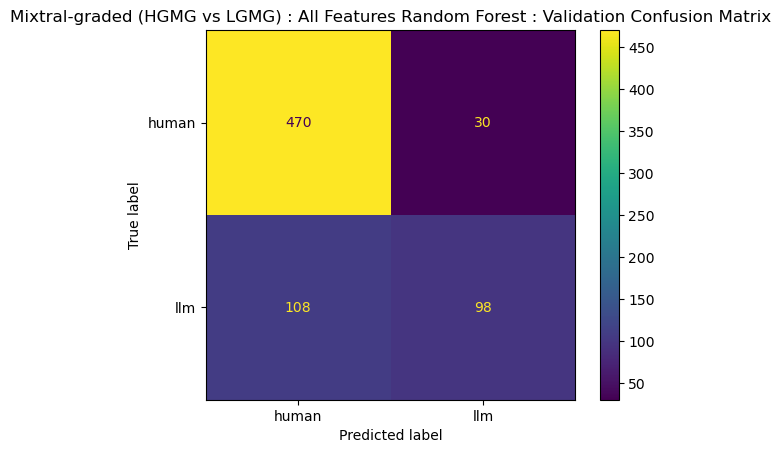

sym4_detail_kurt          0.080320
db2_detail_kurt           0.059785
coif1_detail_kurt         0.059605
sym4_detail_entropy       0.039772
bior3.3_detail_entropy    0.034613
db4_detail_kurt           0.033148
coif1_detail_entropy      0.032012
db4_detail_entropy        0.031918
db2_detail_entropy        0.031757
bior3.3_detail_kurt       0.029720
db4_detailL1_ratio        0.021561
db8_detailL2_ratio        0.021467
sym4_detailL2_ratio       0.019791
db8_detailL3_ratio        0.018628
bior3.3_detailL1_ratio    0.017883
db4_detailL5_ratio        0.017784
db8_detail_kurt           0.017712
sym4_detailL1_ratio       0.017672
db4_detailL3_ratio        0.017256
db2_wavelet_hf_ratio      0.017018
dtype: float64

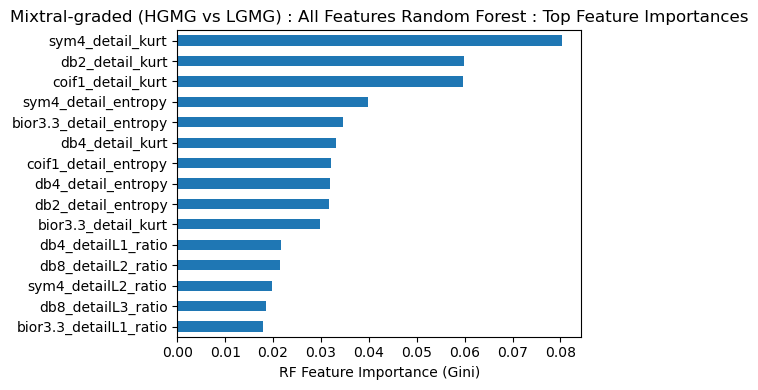

In [82]:
all_features = hf_ratio_features + detail_ratio_features + detail_kurt_features + detail_entropy_features
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-graded (HGMG vs LGMG) : All Features Random Forest'
)

## RESULTS (Reuters Llama-Generated, Mixtral-Graded)
**0.729 F1 score** on Reuters Llama-Generated, Mixtral-Graded.  Not very good.

# <a color="red"><u>REUTERS</u></a>

## Mixtral-Generated, Llama-Graded

## Build Wavelet-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (MGLG) Reuters documents 


In [83]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_MIXTRAL_LLAMA)
df_llama.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.755326,0.029937,0.036022,0.128200,0.204772,0.356394,3.615790,0.890629,0.593908,0.023346,...,0.080082,0.200206,0.172796,0.102765,3.475690,1.477242,1.0,human,human_0,NaN
1,0.874567,0.014252,0.082350,0.109653,0.194552,0.473760,3.536350,1.309365,0.885311,0.028366,...,0.151818,0.181998,0.164778,0.109516,3.297332,2.668546,1.0,human,human_1,0.417128
2,0.394169,0.029797,0.040767,0.114736,0.208870,NaN,3.525299,0.067251,0.654021,0.072107,...,0.202365,0.081304,NaN,NaN,2.984706,5.017521,1.0,human,human_2,NaN
3,0.659600,0.025322,0.046706,0.076047,0.181548,0.329976,3.584786,1.352461,0.555807,0.015675,...,0.102001,0.077164,0.115666,0.073059,3.258352,2.762108,1.0,human,human_3,0.332370
4,0.577642,0.023624,0.025179,0.054954,0.166890,0.306995,3.485271,1.737032,0.462182,0.014053,...,0.075080,0.055075,0.102402,0.059672,3.371501,1.825228,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [84]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,bior3.3_detail_kurt,<=,15.456516,False,0.979189,0.982026,0.967905,0.963840,0.985390,0.974615,0.022986,0.977044,0.973649,0.970935,0.960784,0.983773,0.972279,0.007446
1,db4_detail_kurt,<=,2.771850,False,0.960172,0.959723,0.943804,0.930495,0.972090,0.951292,0.026276,0.975610,0.975350,0.965650,0.957816,0.982846,0.970331,0.011501
2,db8_detail_kurt,<=,3.644693,False,0.950843,0.946754,0.934004,0.914642,0.965482,0.940062,0.036841,0.956958,0.954439,0.941057,0.925000,0.969819,0.947409,0.031816
4,coif1_detail_kurt,<=,3.077372,False,0.947255,0.951494,0.920845,0.905466,0.963424,0.934445,0.034186,0.954089,0.950879,0.937602,0.920000,0.967807,0.943903,0.016855
0,db2_detail_kurt,<=,2.860762,False,0.946179,0.943145,0.926096,0.905779,0.962330,0.934055,0.043841,0.952654,0.952647,0.932317,0.916456,0.966967,0.941711,0.029328
3,sym4_detail_kurt,<=,2.368248,False,0.942949,0.947583,0.914253,0.897220,0.960517,0.928868,0.049371,0.944046,0.939067,0.924797,0.902256,0.960804,0.931530,0.025292


In [85]:
results = []
for feat in detail_entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,bior3.3_detail_entropy,>=,2.514847,False,0.986724,0.988074,0.979971,0.977175,0.990640,0.983907,0.996984,0.981349,0.979543,0.975407,0.968059,0.986829,0.977444,0.998701
1,db4_detail_entropy,>=,3.210921,False,0.969501,0.968404,0.957850,0.947303,0.978541,0.962922,0.990602,0.978479,0.976058,0.971951,0.963145,0.984802,0.973974,0.994844
4,coif1_detail_entropy,>=,3.227067,False,0.947614,0.950533,0.922514,0.906530,0.963609,0.935070,0.974595,0.956958,0.960428,0.935366,0.923469,0.970060,0.946765,0.978911
0,db2_detail_entropy,>=,3.182219,False,0.953714,0.959398,0.928963,0.917148,0.967886,0.942517,0.981580,0.952654,0.955742,0.929472,0.915601,0.967099,0.941350,0.975907
2,db8_detail_entropy,>=,3.044496,False,0.944026,0.950478,0.914309,0.898701,0.961329,0.930015,0.979337,0.949785,0.958899,0.920325,0.908616,0.965381,0.936998,0.979070
3,sym4_detail_entropy,>=,3.282903,False,0.932185,0.941778,0.894590,0.874751,0.953506,0.914129,0.955335,0.936872,0.939430,0.906911,0.886010,0.956349,0.921180,0.966587


In [86]:
results = []
for feat in hf_ratio_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
0,db2_wavelet_hf_ratio,>=,0.380812,False,0.978113,0.972906,0.974571,0.963008,0.984459,0.973733,0.996158,0.982783,0.980600,0.977846,0.970588,0.987830,0.979209,0.996986
3,sym4_wavelet_hf_ratio,>=,0.380233,False,0.973448,0.971328,0.964541,0.954433,0.981266,0.967850,0.995040,0.968436,0.967234,0.956301,0.945274,0.977823,0.961548,0.996232
4,coif1_wavelet_hf_ratio,>=,0.393514,False,0.968784,0.962622,0.962295,0.947048,0.977868,0.962458,0.993666,0.967001,0.962116,0.958130,0.943489,0.976697,0.960093,0.995499
1,db4_wavelet_hf_ratio,>=,0.467496,False,0.890922,0.863947,0.882665,0.823461,0.921080,0.872271,0.950286,0.878049,0.849676,0.863821,0.800000,0.912281,0.856140,0.946639
5,bior3.3_wavelet_hf_ratio,>=,0.513132,False,0.753140,0.743258,0.791677,0.679104,0.799417,0.739261,0.813973,0.771879,0.752213,0.800000,0.691262,0.819113,0.755187,0.837785
2,db8_wavelet_hf_ratio,>=,0.509728,False,0.756369,0.721684,0.635102,0.451091,0.843440,0.647266,0.774571,0.725968,0.660784,0.596748,0.377850,0.824287,0.601069,0.753123


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest
accuracy (val):        0.994
precision_macro (val): 0.995
recall_macro (val):    0.992
f1_macro (val):        0.993
AUROC (val):           1.000


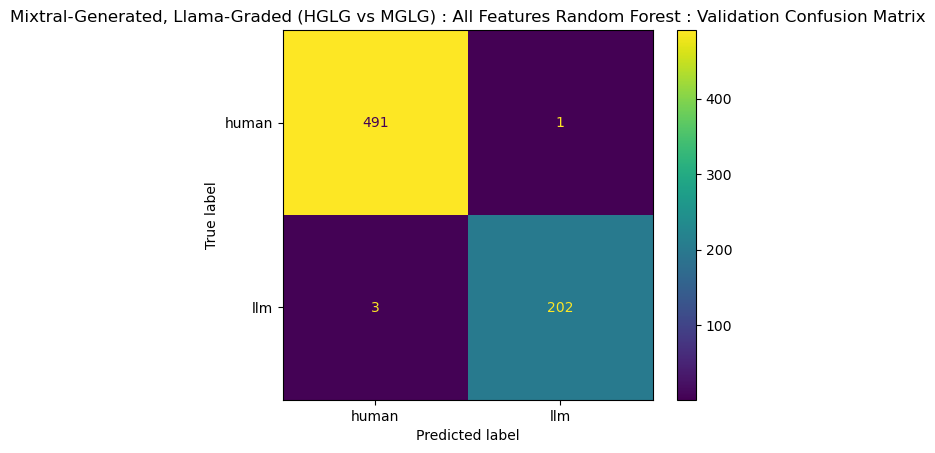

bior3.3_detail_entropy    0.145744
bior3.3_detail_kurt       0.103239
db2_wavelet_hf_ratio      0.094250
db2_detailL4_ratio        0.081300
sym4_wavelet_hf_ratio     0.078776
coif1_wavelet_hf_ratio    0.059053
sym4_detailL5_ratio       0.050901
db2_detailL3_ratio        0.049783
db4_detail_entropy        0.048262
db2_detailL5_ratio        0.047396
db4_detail_kurt           0.040820
bior3.3_detailL5_ratio    0.035266
db2_detail_entropy        0.022369
db8_detail_kurt           0.014464
db2_detail_kurt           0.011884
coif1_detail_entropy      0.011115
coif1_detail_kurt         0.010256
coif1_detailL5_ratio      0.009432
sym4_detailL4_ratio       0.008973
sym4_detailL3_ratio       0.008866
dtype: float64

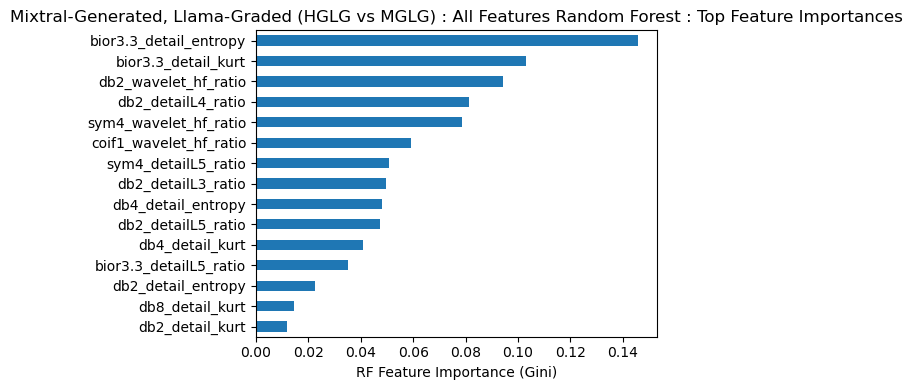

In [87]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Generated, Llama-Graded (HGLG vs MGLG) : All Features Random Forest'
)

## RESULTS (Reuters Mixtral-Generated, Llama-Graded)
0.993 F1 score for Mixtral-Generated, Llama-Graded.  Amazing separation!

# Llama-Generated, Llama-Graded (SAME MODEL) Reuters

## Build Wavelet-Only Feature DataFrame (HGLG vs LGLG)

We now build a dataframe of features for:

- Human-generated, Llama-graded (HGLG) Reuters documents
- Mixtral-generated, Llama-graded (LGLG) Reuters documents 


In [88]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_REUTERS_LLAMA, LLM_REUTERS_LLAMA_LLAMA)
df_llama.head()


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.755326,0.029937,0.036022,0.128200,0.204772,0.356394,3.615790,0.890629,0.593908,0.023346,...,0.080082,0.200206,0.172796,0.102765,3.475690,1.477242,1.0,human,human_0,NaN
1,0.874567,0.014252,0.082350,0.109653,0.194552,0.473760,3.536350,1.309365,0.885311,0.028366,...,0.151818,0.181998,0.164778,0.109516,3.297332,2.668546,1.0,human,human_1,0.417128
2,0.394169,0.029797,0.040767,0.114736,0.208870,NaN,3.525299,0.067251,0.654021,0.072107,...,0.202365,0.081304,NaN,NaN,2.984706,5.017521,1.0,human,human_2,NaN
3,0.659600,0.025322,0.046706,0.076047,0.181548,0.329976,3.584786,1.352461,0.555807,0.015675,...,0.102001,0.077164,0.115666,0.073059,3.258352,2.762108,1.0,human,human_3,0.332370
4,0.577642,0.023624,0.025179,0.054954,0.166890,0.306995,3.485271,1.737032,0.462182,0.014053,...,0.075080,0.055075,0.102402,0.059672,3.371501,1.825228,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Deep Dive: Threshold Search and Random Forest

We now isolate **Wavelet features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [89]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,sym4_detail_kurt,<=,2.119983,False,0.941123,0.941117,0.936898,0.927083,0.950630,0.938857,0.022788,0.944778,0.944921,0.940652,0.931548,0.953722,0.942635,0.021821
4,coif1_detail_kurt,<=,2.592223,False,0.942325,0.942719,0.937803,0.928412,0.951710,0.940061,0.023428,0.935174,0.934465,0.931171,0.919881,0.945565,0.932723,0.023097
0,db2_detail_kurt,<=,2.727241,False,0.940523,0.944540,0.932913,0.924658,0.950868,0.937763,0.020575,0.933974,0.933010,0.930155,0.918519,0.944501,0.931510,0.023931
1,db4_detail_kurt,<=,2.124047,False,0.939622,0.938449,0.936522,0.925803,0.949101,0.937452,0.021315,0.930372,0.928691,0.927106,0.914454,0.941296,0.927875,0.023437
2,db8_detail_kurt,<=,2.355325,False,0.898768,0.894741,0.896535,0.877410,0.913789,0.895599,0.040708,0.903962,0.899975,0.902049,0.883721,0.918200,0.900961,0.043529
5,bior3.3_detail_kurt,<=,5.247471,False,0.817663,0.811552,0.818303,0.786943,0.840641,0.813792,0.111889,0.806723,0.800066,0.805331,0.771631,0.832466,0.802049,0.118929


In [90]:
results = []
for feat in detail_entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
3,sym4_detail_entropy,>=,3.363920,False,0.902974,0.902563,0.896061,0.878708,0.919149,0.898929,0.956076,0.911164,0.909450,0.906346,0.890208,0.925403,0.907805,0.960083
0,db2_detail_entropy,>=,3.288639,False,0.905677,0.907419,0.897006,0.880608,0.922046,0.901327,0.956318,0.907563,0.905181,0.903297,0.886263,0.922144,0.904203,0.956834
4,coif1_detail_entropy,>=,3.314296,False,0.907780,0.907176,0.901478,0.885062,0.923000,0.904031,0.958618,0.901561,0.900182,0.895516,0.877612,0.917671,0.897641,0.962169
1,db4_detail_entropy,>=,3.304766,False,0.892160,0.894606,0.881744,0.862294,0.911380,0.886837,0.951197,0.897959,0.898831,0.889317,0.871017,0.915591,0.893304,0.950796
2,db8_detail_entropy,>=,3.266544,False,0.829078,0.825562,0.818666,0.784877,0.858211,0.821544,0.913741,0.840336,0.837127,0.830636,0.799397,0.867398,0.833397,0.918014
5,bior3.3_detail_entropy,>=,2.969438,False,0.808351,0.801601,0.805145,0.770998,0.835227,0.803113,0.880972,0.797119,0.790133,0.790901,0.753285,0.827727,0.790506,0.874514


Llama-Generated, Llama-Graded (HGLG vs LGLG) : Wavelet HF Ratio Random Forest
accuracy (val):        0.920
precision_macro (val): 0.919
recall_macro (val):    0.914
f1_macro (val):        0.916
AUROC (val):           0.974


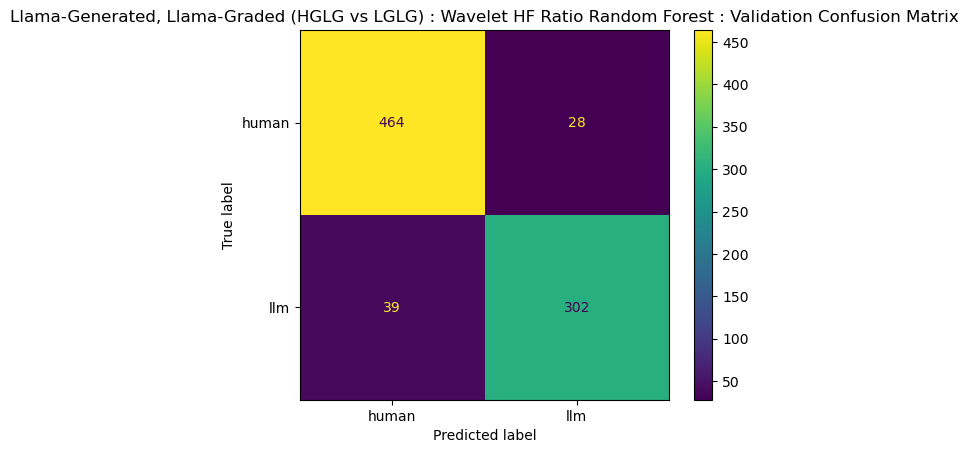

db2_wavelet_hf_ratio        0.254404
sym4_wavelet_hf_ratio       0.252888
coif1_wavelet_hf_ratio      0.244097
db4_wavelet_hf_ratio        0.122116
bior3.3_wavelet_hf_ratio    0.077934
db8_wavelet_hf_ratio        0.048561
dtype: float64

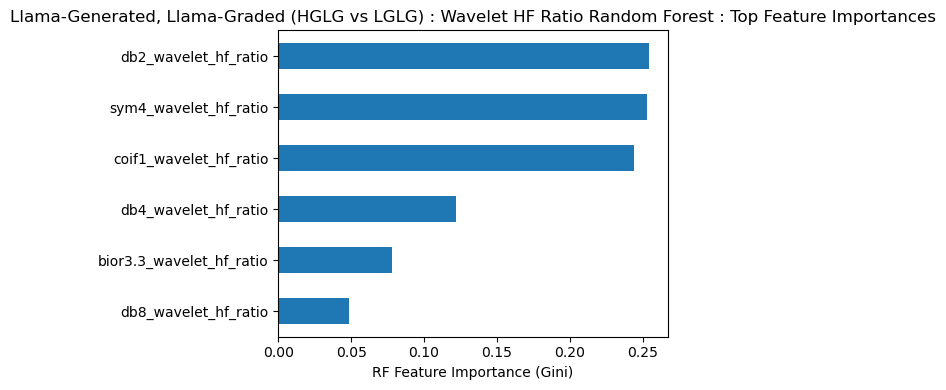

In [91]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=hf_ratio_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : Wavelet HF Ratio Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest
accuracy (val):        0.966
precision_macro (val): 0.967
recall_macro (val):    0.964
f1_macro (val):        0.965
AUROC (val):           0.994


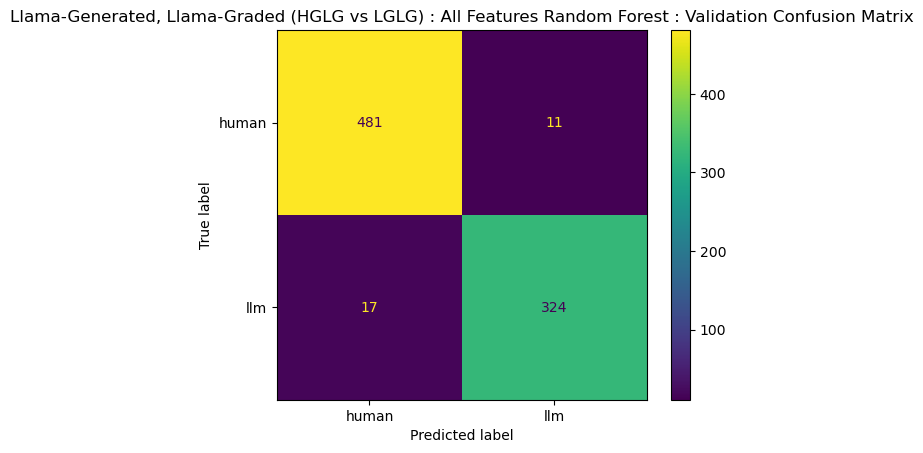

coif1_detail_kurt         0.112363
db2_detail_kurt           0.106599
sym4_detail_kurt          0.105164
db4_detail_kurt           0.084355
sym4_wavelet_hf_ratio     0.079028
sym4_detailL5_ratio       0.069365
coif1_wavelet_hf_ratio    0.057469
db2_wavelet_hf_ratio      0.051238
coif1_detailL5_ratio      0.041924
coif1_detail_entropy      0.034380
sym4_detail_entropy       0.030857
db2_detail_entropy        0.029275
db2_detailL5_ratio        0.023321
db4_detail_entropy        0.020049
db4_detailL5_ratio        0.019820
db8_detail_kurt           0.017331
coif1_detailL4_ratio      0.012973
db2_detailL4_ratio        0.012045
db4_detailL4_ratio        0.010269
sym4_detailL4_ratio       0.007766
dtype: float64

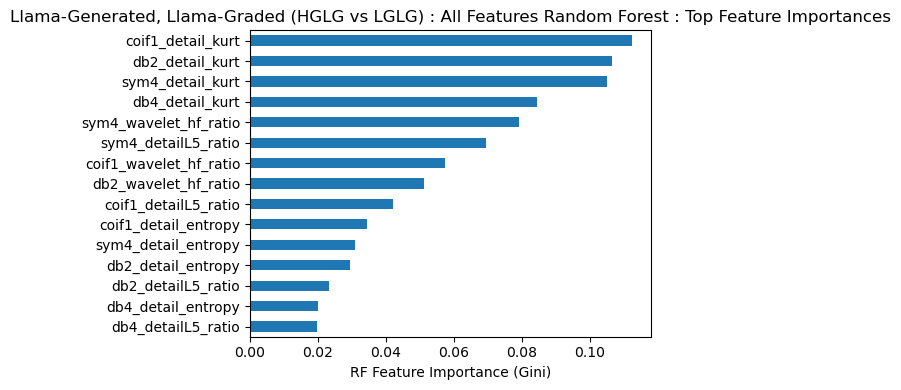

In [92]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Generated, Llama-Graded (HGLG vs LGLG) : All Features Random Forest'
)

## RESULTS (Reuters Llama-Generated, Llama-Graded)
0.965 F1 score for Llama-Generated, Llama-Graded.  Separation is great, but it is interesting that it is not as high as Mixtral-Generated, Llama-Graded.

# <a color="red"><u>HC3</u></a>

## Llama-Graded

## Build Wavelet-Only Feature DataFrame

We now build a dataframe of features for HC3 Llama-Graded:


In [93]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_HC3_LLAMA, LLM_HC3_LLAMA)
df_llama.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.485109,0.017603,0.058999,0.052817,0.116623,0.239068,3.571537,0.936026,0.239080,0.015577,...,0.096443,0.046863,0.081346,0.044422,3.245976,4.095168,1.0,human,human_0,NaN
1,0.716420,0.030268,0.053396,0.105780,0.197616,0.329360,3.553389,0.670799,0.763562,0.018917,...,0.065780,0.165986,0.188862,0.097188,3.429047,2.003959,1.0,human,human_1,NaN
2,0.623281,0.043066,0.020683,0.071548,0.141608,0.346376,3.695015,0.212454,0.690199,0.023443,...,0.159847,0.136396,0.172993,0.106542,3.090734,4.285735,1.0,human,human_2,NaN
3,0.667552,0.037369,0.043014,0.133722,0.144695,0.308753,3.761960,0.137765,0.824314,0.070626,...,0.080482,0.145092,0.195801,0.073595,3.343340,2.656134,1.0,human,human_3,NaN
4,0.699648,0.032263,0.051162,0.085116,0.230875,0.300233,3.666348,0.428787,0.615696,0.025941,...,0.069783,0.119502,0.126022,0.072402,3.395081,1.684714,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [94]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

# Run threshold search for each feature
results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,coif1_detail_kurt,<=,2.914953,False,0.902025,0.900270,0.900047,0.886503,0.913813,0.900158,0.042353,0.908728,0.906171,0.908743,0.895833,0.918782,0.907308,0.037760
0,db2_detail_kurt,<=,2.831554,False,0.900599,0.898564,0.899028,0.885267,0.912316,0.898792,0.044242,0.898460,0.895774,0.898280,0.884115,0.909645,0.896880,0.043209
3,sym4_detail_kurt,<=,2.292068,False,0.891900,0.889340,0.891014,0.876103,0.904123,0.890113,0.048751,0.897889,0.895174,0.897778,0.883539,0.909091,0.896315,0.043061
1,db4_detail_kurt,<=,2.629242,False,0.894609,0.894222,0.890519,0.875861,0.908438,0.892149,0.047537,0.895037,0.893556,0.892257,0.877660,0.908092,0.892876,0.044992
2,db8_detail_kurt,<=,2.405141,False,0.885625,0.883375,0.883674,0.867875,0.899170,0.883523,0.053453,0.888762,0.885898,0.888636,0.873294,0.900864,0.887079,0.051940
5,bior3.3_detail_kurt,<=,5.192422,False,0.822590,0.820430,0.816694,0.790219,0.846306,0.818263,0.094780,0.831147,0.828992,0.825730,0.800808,0.853465,0.827136,0.090208


In [95]:
results = []
for feat in detail_entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,coif1_detail_entropy,>=,3.280484,False,0.819452,0.820057,0.826043,0.807189,0.830249,0.818719,0.864302,0.825442,0.828212,0.834023,0.816106,0.833876,0.824991,0.863376
0,db2_detail_entropy,>=,3.250564,False,0.815317,0.813021,0.818338,0.797308,0.830386,0.813847,0.862387,0.812892,0.812332,0.818224,0.798278,0.825532,0.811905,0.857541
3,sym4_detail_entropy,>=,3.355907,False,0.785653,0.792327,0.796166,0.778873,0.792030,0.785451,0.824281,0.780947,0.791089,0.793440,0.777262,0.784512,0.780887,0.818347
1,db4_detail_entropy,>=,3.284862,False,0.787935,0.786808,0.792099,0.770277,0.803072,0.786674,0.832664,0.776383,0.776741,0.781975,0.760684,0.790150,0.775417,0.829372
5,bior3.3_detail_entropy,>=,3.002605,False,0.762407,0.758831,0.762285,0.734713,0.784866,0.759790,0.833704,0.764974,0.762050,0.766229,0.740227,0.785417,0.762822,0.832682
2,db8_detail_entropy,>=,3.283960,False,0.768112,0.769620,0.774567,0.753935,0.780744,0.767339,0.819415,0.755847,0.760866,0.764853,0.746145,0.764835,0.755490,0.814034


Llama-Graded HC3 : Wavelet HF Ratio Random Forest
accuracy (val):        0.917
precision_macro (val): 0.915
recall_macro (val):    0.918
f1_macro (val):        0.916
AUROC (val):           0.967


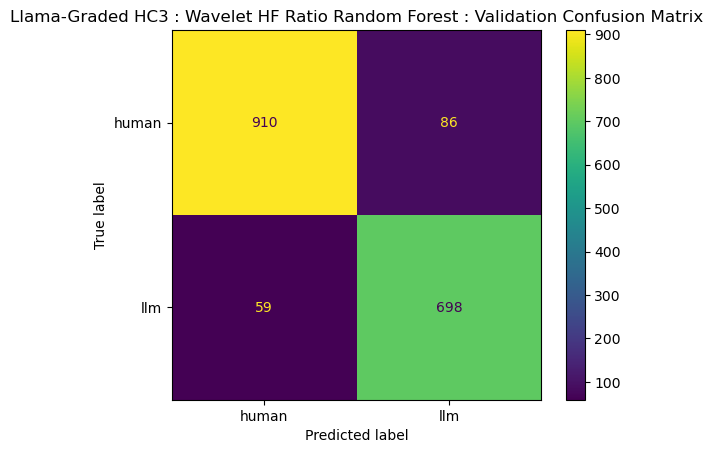

sym4_wavelet_hf_ratio       0.285012
coif1_wavelet_hf_ratio      0.225725
db4_wavelet_hf_ratio        0.163377
db2_wavelet_hf_ratio        0.155076
bior3.3_wavelet_hf_ratio    0.102523
db8_wavelet_hf_ratio        0.068287
dtype: float64

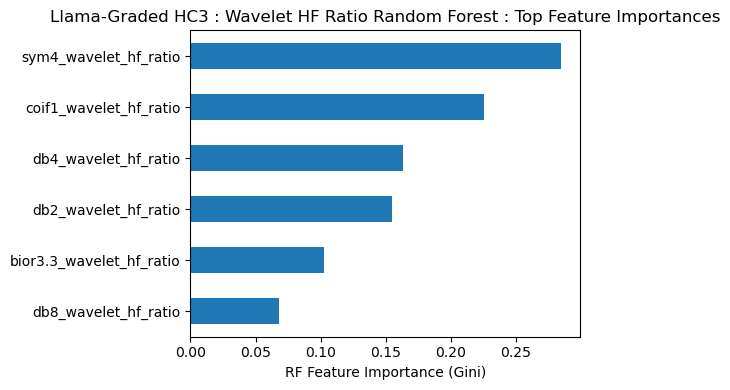

In [96]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=hf_ratio_features,
    title='Llama-Graded HC3 : Wavelet HF Ratio Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded HC3 : All Features Random Forest
accuracy (val):        0.959
precision_macro (val): 0.957
recall_macro (val):    0.960
f1_macro (val):        0.958
AUROC (val):           0.990


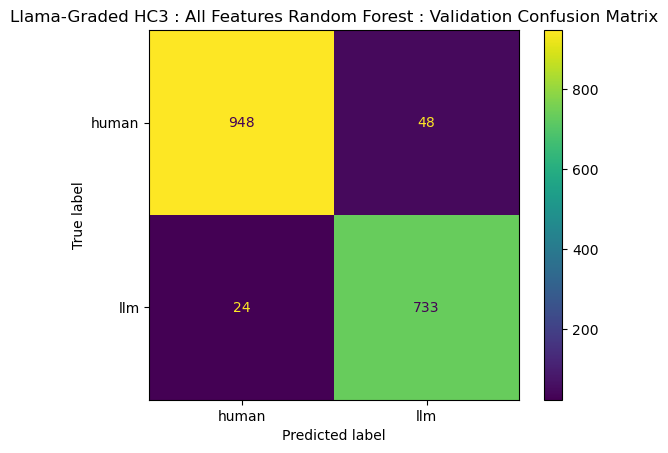

coif1_detail_kurt         0.118221
db2_detail_kurt           0.096347
sym4_detail_kurt          0.079282
db4_detail_kurt           0.069010
sym4_detailL4_ratio       0.063970
db4_detailL4_ratio        0.058436
sym4_detailL3_ratio       0.058147
db8_detail_kurt           0.051568
coif1_detailL4_ratio      0.042099
sym4_detailL5_ratio       0.040271
db4_detailL5_ratio        0.024561
bior3.3_detailL5_ratio    0.021319
sym4_wavelet_hf_ratio     0.019371
coif1_detailL3_ratio      0.018918
coif1_detailL5_ratio      0.018705
coif1_detail_entropy      0.018375
db4_detailL2_ratio        0.016405
db2_detailL4_ratio        0.016257
sym4_detail_entropy       0.013851
db2_detail_entropy        0.010977
dtype: float64

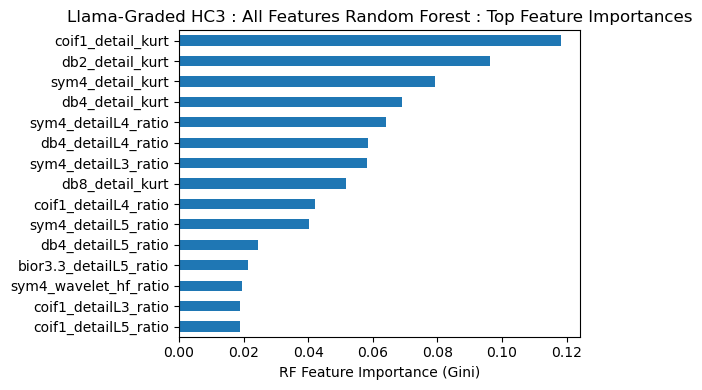

In [97]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Llama-Graded)
0.958 F1 score.  Very good separation.

# <a color="red"><u>HC3</u></a>

## Mixtral-Graded

## Build Wavelet-Only Feature DataFrame

We now build a dataframe of features for HC3 Mixtral-Graded:


In [98]:
# Build the core dataframe for HGMG vs LGMG
df_mixtral = build_feature_df(HUMAN_HC3_MIXTRAL, LLM_HC3_MIXTRAL)
df_mixtral.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.358115,0.020978,0.033197,0.046897,0.093629,0.163414,3.585576,1.012656,0.222806,0.009696,...,0.065465,0.052881,0.056714,0.031431,2.979543,6.147953,1.0,human,human_0,NaN
1,0.568340,0.012749,0.033579,0.099518,0.136880,0.285614,3.636658,0.567961,0.641881,0.022808,...,0.085696,0.135156,0.127206,0.075179,2.805148,8.693836,1.0,human,human_1,NaN
2,0.605051,0.026978,0.038008,0.083240,0.124567,0.332259,3.639865,1.086363,0.690617,0.017802,...,0.128456,0.166817,0.118068,0.058344,2.833727,7.656781,1.0,human,human_2,NaN
3,0.670314,0.027802,0.044025,0.102570,0.189921,0.305996,3.627049,0.517840,0.707478,0.061172,...,0.119237,0.101932,0.140241,0.049871,3.274067,3.162781,1.0,human,human_3,NaN
4,0.582318,0.022015,0.024575,0.080202,0.162218,0.293309,3.610878,0.979025,0.560516,0.022988,...,0.058066,0.118531,0.120931,0.055003,2.941723,6.113724,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [99]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
4,coif1_detail_kurt,<=,3.394720,False,0.952895,0.944032,0.948516,0.927276,0.965166,0.946221,0.018561,0.957240,0.948415,0.954228,0.934116,0.968348,0.951232,0.017056
3,sym4_detail_kurt,<=,2.482873,False,0.950355,0.938137,0.950392,0.924707,0.962969,0.943838,0.019390,0.945809,0.932141,0.946864,0.918263,0.959468,0.938866,0.019488
0,db2_detail_kurt,<=,3.288009,False,0.940510,0.928075,0.937397,0.909208,0.955762,0.932485,0.022542,0.944962,0.932689,0.943100,0.916129,0.959042,0.937586,0.020911
1,db4_detail_kurt,<=,3.607500,False,0.909072,0.890399,0.907810,0.864490,0.931581,0.898035,0.036508,0.920830,0.903431,0.920806,0.881720,0.940503,0.911112,0.034497
2,db8_detail_kurt,<=,3.330060,False,0.891712,0.872704,0.883012,0.835715,0.919239,0.877477,0.050149,0.904742,0.887532,0.897103,0.854932,0.929089,0.892011,0.046724
5,bior3.3_detail_kurt,<=,12.989114,False,0.876998,0.856121,0.866694,0.813782,0.908171,0.860977,0.055601,0.877223,0.858192,0.861150,0.809961,0.909318,0.859640,0.051257


In [100]:
results = []
for feat in detail_ratio_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
16,sym4_detailL3_ratio,>=,0.044121,False,0.754737,0.738419,0.770515,0.680546,0.800962,0.740754,NaN,0.747671,0.733440,0.765823,0.674672,0.793914,0.734293,NaN
15,sym4_detailL2_ratio,>=,0.030709,False,0.752726,0.728329,0.753966,0.662720,0.804813,0.733767,NaN,0.738781,0.715192,0.740436,0.646418,0.792884,0.719651,NaN
21,coif1_detailL3_ratio,>=,0.036364,False,0.759289,0.726776,0.739548,0.645905,0.817672,0.731788,NaN,0.746825,0.713545,0.726463,0.629032,0.807841,0.718436,NaN
5,db4_detailL1_ratio,>=,0.019433,False,0.749338,0.716622,0.730221,0.634003,0.809401,0.721702,0.819196,0.747671,0.712812,0.721852,0.622785,0.810433,0.716609,0.821395
2,db2_detailL3_ratio,>=,0.037665,False,0.751879,0.723863,0.745243,0.652638,0.807015,0.729826,NaN,0.736664,0.707662,0.727362,0.630641,0.795395,0.713018,NaN
6,db4_detailL2_ratio,>=,0.027628,False,0.745422,0.713067,0.727686,0.630852,0.805719,0.718286,NaN,0.741321,0.706288,0.716132,0.615481,0.805104,0.710293,NaN
3,db2_detailL4_ratio,>=,0.062427,False,0.711760,0.680969,0.697508,0.594127,0.776529,0.685328,NaN,0.707451,0.677125,0.694002,0.589911,0.772623,0.681267,NaN
25,bior3.3_detailL2_ratio,>=,0.043757,False,0.707209,0.656439,0.632492,0.481634,0.795988,0.638811,NaN,0.707028,0.656326,0.634364,0.485884,0.795145,0.640515,NaN
20,coif1_detailL2_ratio,>=,0.028677,False,0.696835,0.650850,0.648808,0.521390,0.778156,0.649773,NaN,0.677815,0.631239,0.632412,0.501637,0.761964,0.631801,NaN
1,db2_detailL2_ratio,>=,0.020585,False,0.693871,0.642700,0.632255,0.491024,0.781108,0.636066,NaN,0.682896,0.626864,0.614164,0.460763,0.775412,0.618088,NaN


Mixtral-Graded HC3 : Wavelet Detail Entropy Random Forest
accuracy (val):        0.964
precision_macro (val): 0.958
recall_macro (val):    0.961
f1_macro (val):        0.959
AUROC (val):           0.993


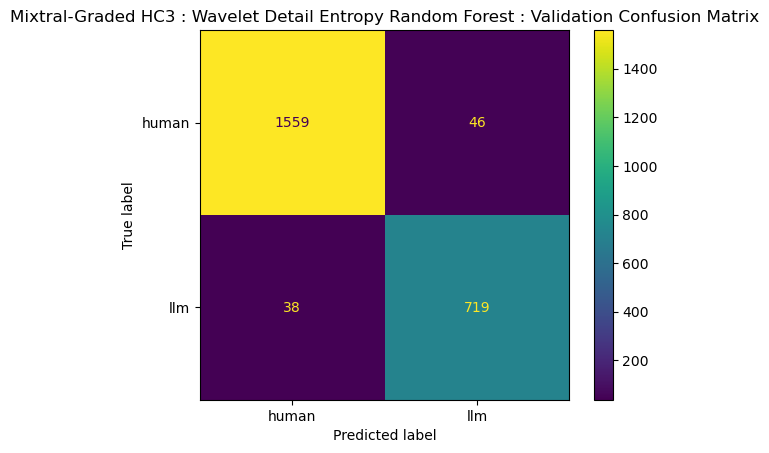

db2_detail_entropy        0.270594
coif1_detail_entropy      0.222826
bior3.3_detail_entropy    0.213807
sym4_detail_entropy       0.151775
db4_detail_entropy        0.109373
db8_detail_entropy        0.031625
dtype: float64

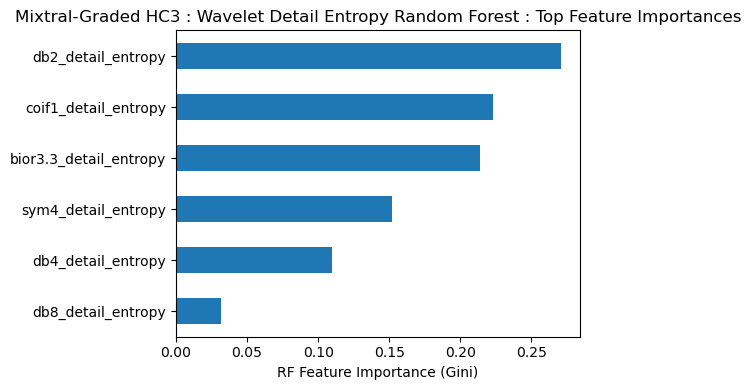

In [101]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=detail_entropy_features,
    title='Mixtral-Graded HC3 : Wavelet Detail Entropy Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded HC3 : All Features Random Forest
accuracy (val):        0.981
precision_macro (val): 0.977
recall_macro (val):    0.979
f1_macro (val):        0.978
AUROC (val):           0.998


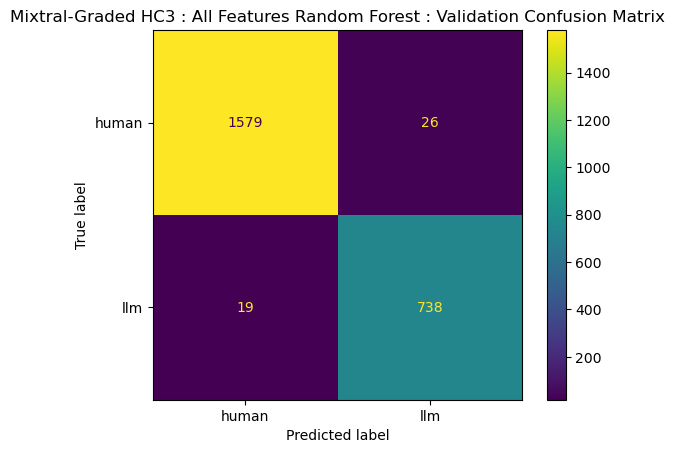

coif1_detail_kurt         0.150090
sym4_detail_kurt          0.125099
db2_detail_kurt           0.107704
db4_detail_kurt           0.063958
db8_detail_kurt           0.054737
bior3.3_detailL5_ratio    0.052918
db2_detail_entropy        0.052407
bior3.3_detail_entropy    0.049464
bior3.3_detail_kurt       0.046424
coif1_detail_entropy      0.040900
sym4_detail_entropy       0.036274
sym4_detailL3_ratio       0.024790
db4_detail_entropy        0.020356
sym4_detailL5_ratio       0.017703
db4_detailL2_ratio        0.012495
sym4_detailL4_ratio       0.012383
sym4_detailL2_ratio       0.012133
coif1_detailL3_ratio      0.007851
coif1_detailL5_ratio      0.007466
db4_detailL1_ratio        0.007341
dtype: float64

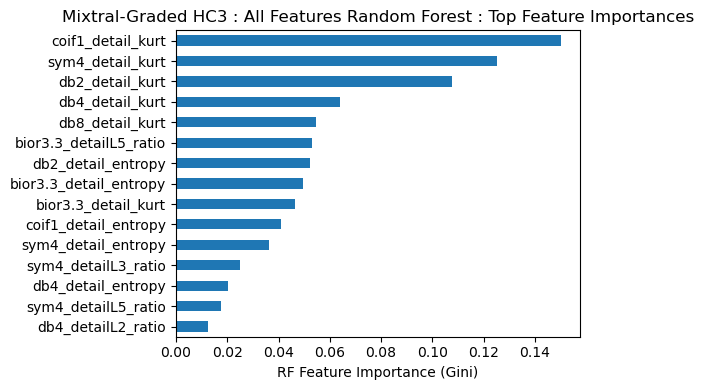

In [102]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded HC3 : All Features Random Forest'
)

## RESULTS (HC3, Mixtral-Graded)
0.978 F1 score.  Almost perfect separation.  

# <a color="red"><u>MAGE</u></a>

## Llama-Graded

## Build Wavelet-Only Feature DataFrame

We now build a dataframe of features for MAGE Llama-Graded:


In [103]:
# Build the core dataframe for HGMG vs LGMG
df_llama = build_feature_df(HUMAN_MAGE_LLAMA, LLM_MAGE_LLAMA)
df_llama.head()


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.234296,0.024962,0.011945,0.027781,0.054870,0.114738,3.287223,2.295599,0.184855,0.009154,...,0.017727,0.035747,0.037041,0.021313,2.819520,9.190396,1.0,human,human_0,NaN
1,0.290414,0.047332,0.047265,0.035564,0.060053,0.100199,3.071032,6.218131,0.442397,0.020216,...,0.123515,0.086266,0.054824,0.027096,2.476406,17.852681,1.0,human,human_1,NaN
2,0.198658,0.031343,0.010965,0.025237,0.048008,0.083105,3.177364,4.217620,0.296364,0.021693,...,0.018454,0.047762,0.026369,0.022076,2.431488,23.709483,1.0,human,human_2,NaN
3,0.885656,0.043444,0.080175,0.099532,0.215868,0.446636,3.632672,0.631882,0.783940,0.030624,...,0.185252,0.152114,0.217732,0.121868,3.344631,2.394988,1.0,human,human_3,NaN
4,0.494646,0.076857,0.056161,0.053553,0.097391,0.210684,3.181840,2.928038,0.463086,0.039753,...,0.146025,0.052312,0.077866,0.043539,2.767467,11.992059,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [104]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_llama, test_size=0.2, seed=42)

results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
5,bior3.3_detail_kurt,>=,4.738333,False,0.623724,0.638501,0.626051,0.670636,0.561230,0.615933,0.654944,0.620748,0.629971,0.622414,0.659542,0.571977,0.615759,0.651504
1,db4_detail_kurt,>=,1.751233,False,0.610544,0.640510,0.613903,0.678145,0.506997,0.592571,0.623145,0.600340,0.622438,0.603066,0.664765,0.505263,0.585014,0.607128
2,db8_detail_kurt,>=,2.025063,False,0.627551,0.655437,0.630640,0.687589,0.538947,0.613268,0.649441,0.593537,0.612083,0.596124,0.656115,0.503119,0.579617,0.627864
3,sym4_detail_kurt,>=,2.070736,False,0.590136,0.641622,0.594570,0.679947,0.430260,0.555103,0.575468,0.591837,0.655725,0.596066,0.686684,0.414634,0.550659,0.585200
0,db2_detail_kurt,>=,2.599562,False,0.596939,0.659276,0.601570,0.688363,0.429603,0.558983,0.589947,0.585034,0.638875,0.589123,0.678947,0.413462,0.546204,0.583372
4,coif1_detail_kurt,>=,2.629420,False,0.592687,0.657957,0.597448,0.687133,0.416565,0.551849,0.577746,0.569728,0.624371,0.574069,0.671855,0.375309,0.523582,0.598716


In [105]:
results = []
for feat in detail_entropy_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df

,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
1,db4_detail_entropy,<=,3.376402,False,0.617772,0.642224,0.620774,0.677893,0.530058,0.603975,0.356066,0.619048,0.643219,0.621708,0.679083,0.531381,0.605232,0.368711
5,bior3.3_detail_entropy,<=,3.094444,False,0.625000,0.632172,0.626605,0.657609,0.585526,0.621568,0.347456,0.607143,0.610779,0.608204,0.632750,0.577697,0.605223,0.348311
2,db8_detail_entropy,<=,3.362384,False,0.632228,0.646789,0.634479,0.676636,0.573682,0.625159,0.335595,0.600340,0.610610,0.602233,0.646617,0.540117,0.593367,0.370805
0,db2_detail_entropy,<=,3.369476,False,0.616071,0.635869,0.618813,0.671756,0.537634,0.604695,0.365437,0.602041,0.622395,0.604652,0.663793,0.512500,0.588147,0.390002
4,coif1_detail_entropy,<=,3.345649,False,0.611820,0.650494,0.615537,0.685281,0.493622,0.589451,0.369176,0.591837,0.630140,0.595371,0.673913,0.454545,0.564229,0.360761
3,sym4_detail_entropy,<=,3.363364,False,0.596514,0.644854,0.600761,0.681864,0.448576,0.565220,0.395940,0.586735,0.635378,0.590662,0.677291,0.425532,0.551411,0.399387


Llama-Graded MAGE : Wavelet HF Ratio Random Forest
accuracy (val):        0.636
precision_macro (val): 0.636
recall_macro (val):    0.636
f1_macro (val):        0.636
AUROC (val):           0.679


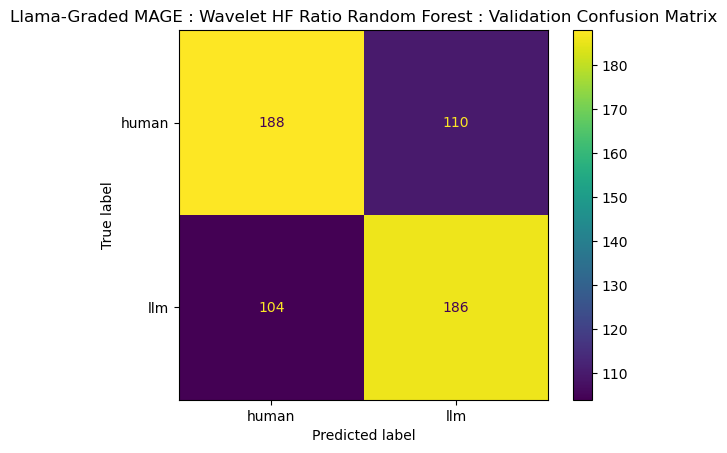

db8_wavelet_hf_ratio        0.188623
sym4_wavelet_hf_ratio       0.184898
coif1_wavelet_hf_ratio      0.173148
db2_wavelet_hf_ratio        0.166076
db4_wavelet_hf_ratio        0.146738
bior3.3_wavelet_hf_ratio    0.140517
dtype: float64

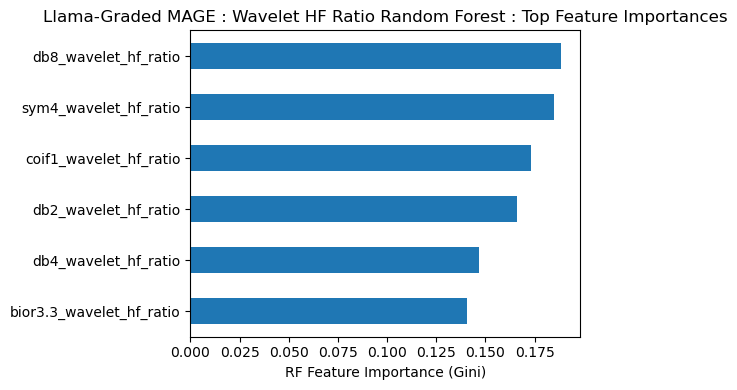

In [106]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=hf_ratio_features,
    title='Llama-Graded MAGE : Wavelet HF Ratio Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Llama-Graded MAGE : All Features Random Forest
accuracy (val):        0.677
precision_macro (val): 0.677
recall_macro (val):    0.677
f1_macro (val):        0.677
AUROC (val):           0.742


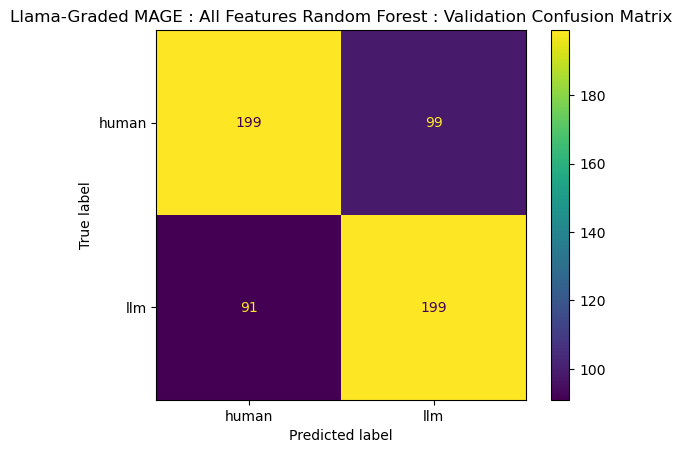

sym4_wavelet_hf_ratio     0.030095
coif1_detail_kurt         0.027865
coif1_detail_entropy      0.027325
sym4_detailL3_ratio       0.027058
db8_detail_entropy        0.026889
db2_detailL4_ratio        0.026341
db8_wavelet_hf_ratio      0.025796
db2_detailL1_ratio        0.025789
sym4_detail_kurt          0.025753
db8_detailL4_ratio        0.025189
db2_detail_entropy        0.024897
db2_detail_kurt           0.024751
db8_detail_kurt           0.024456
coif1_detailL1_ratio      0.023555
db4_detail_kurt           0.023492
db4_detail_entropy        0.023391
sym4_detail_entropy       0.022959
db2_detailL3_ratio        0.022723
sym4_detailL4_ratio       0.022397
coif1_wavelet_hf_ratio    0.022396
dtype: float64

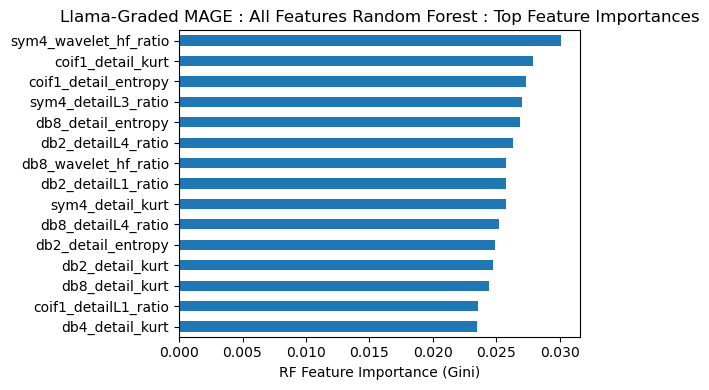

In [107]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Llama-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Llama-Graded)
0.677 F1 score.  Not good separation.

# <a color="red"><u>MAGE</u></a>

## Mixtral-Graded

## Build Wavelet-Only Feature DataFrame

We now build a dataframe of features for MAGE Mixtral-Graded:


In [108]:
# Build the core dataframe for HGMG vs LGMG
df_mixtral = build_feature_df(HUMAN_MAGE_MIXTRAL, LLM_MAGE_MIXTRAL)
df_mixtral.head()


,db2_wavelet_hf_ratio,db2_detailL1_ratio,db2_detailL2_ratio,db2_detailL3_ratio,db2_detailL4_ratio,db2_detailL5_ratio,db2_detail_entropy,db2_detail_kurt,db4_wavelet_hf_ratio,db4_detailL1_ratio,...,bior3.3_detailL2_ratio,bior3.3_detailL3_ratio,bior3.3_detailL4_ratio,bior3.3_detailL5_ratio,bior3.3_detail_entropy,bior3.3_detail_kurt,wavelet_missing,label,doc_id,db8_detailL5_ratio
0,0.264650,0.017127,0.018039,0.042280,0.053477,0.133728,3.207071,3.622243,0.308071,0.018745,...,0.133954,0.114317,0.082214,0.028062,1.984294,35.957226,1.0,human,human_0,NaN
1,0.212827,0.030534,0.006852,0.036264,0.065746,0.073431,2.947912,7.072709,0.241611,0.010220,...,0.036077,0.091539,0.033418,0.017425,2.128942,31.324614,1.0,human,human_1,NaN
2,0.343519,0.016283,0.022604,0.071544,0.075399,0.157690,3.182988,3.837210,0.518726,0.008815,...,0.111476,0.124318,0.093161,0.037589,2.521249,15.091254,1.0,human,human_2,NaN
3,0.234316,0.040003,0.031565,0.028898,0.041287,0.092562,2.953795,8.981658,0.453960,0.024859,...,0.056785,0.088482,0.058603,0.017650,2.151983,30.420905,1.0,human,human_3,NaN
4,0.268386,0.043214,0.015710,0.025960,0.049388,0.134114,3.122567,4.053313,0.293139,0.016396,...,0.038895,0.084391,0.066609,0.024162,2.399712,21.555061,1.0,human,human_4,NaN


## Train / Validation Split

## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


## Feature Deep Dive: Threshold Search and Random Forest

We now isolate **features** and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these features.


In [109]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_mixtral, test_size=0.2, seed=42)

results = []
for feat in detail_kurt_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    results.append(res.__dict__)

results_df = pd.DataFrame(results).sort_values('val_f1_macro', ascending=False)
results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_human,train_f1_llm,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_human,val_f1_llm,val_f1_macro,val_auroc
2,db8_detail_kurt,>=,2.408980,False,0.593040,0.601401,0.593068,0.644026,0.525006,0.584516,0.597865,0.625905,0.638086,0.625785,0.674598,0.560076,0.617337,0.627113
5,bior3.3_detail_kurt,>=,10.517967,False,0.607926,0.609290,0.607937,0.628550,0.584878,0.606714,0.638850,0.612228,0.615175,0.612164,0.641369,0.577933,0.609651,0.629329
1,db4_detail_kurt,>=,2.439615,False,0.609535,0.630163,0.609575,0.674274,0.512679,0.593477,0.601005,0.612228,0.634219,0.612065,0.677807,0.513131,0.595469,0.603570
4,coif1_detail_kurt,>=,2.914119,False,0.601891,0.649175,0.601948,0.689276,0.446124,0.567700,0.574818,0.619469,0.674392,0.619243,0.703076,0.470325,0.586700,0.595697
0,db2_detail_kurt,>=,2.810684,False,0.593442,0.628740,0.593495,0.677723,0.449469,0.563596,0.570440,0.609815,0.648317,0.609610,0.689302,0.475676,0.582489,0.569839
3,sym4_detail_kurt,>=,2.565093,False,0.595856,0.662720,0.595920,0.693890,0.405445,0.549668,0.573923,0.619469,0.686631,0.619227,0.707483,0.455696,0.581590,0.600491


Mixtral-Graded MAGE : Detail Entropy Random Forest
accuracy (val):        0.607
precision_macro (val): 0.610
recall_macro (val):    0.607
f1_macro (val):        0.605
AUROC (val):           0.662


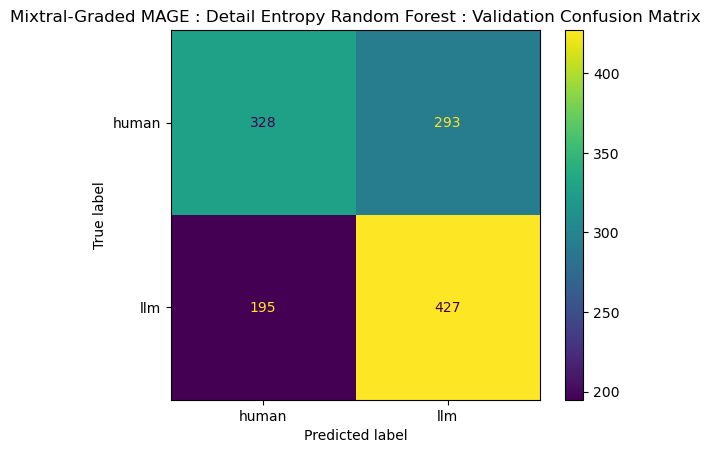

db4_detail_entropy        0.186645
bior3.3_detail_entropy    0.184885
coif1_detail_entropy      0.161301
sym4_detail_entropy       0.160951
db2_detail_entropy        0.155995
db8_detail_entropy        0.150223
dtype: float64

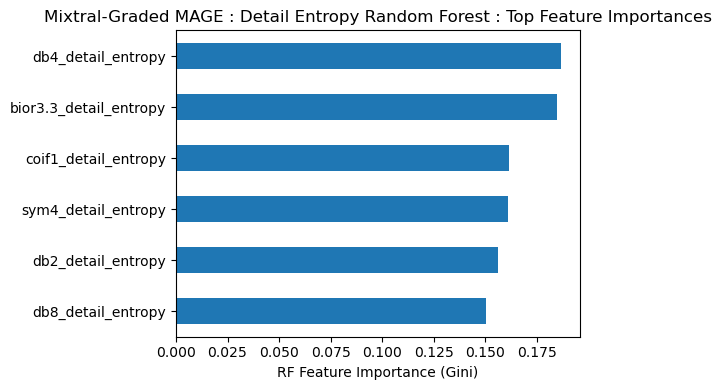

In [110]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=detail_entropy_features,
    title='Mixtral-Graded MAGE : Detail Entropy Random Forest'
)


## All Features

Now we repeat the same procedure using **All features**.


Mixtral-Graded MAGE : All Features Random Forest
accuracy (val):        0.704
precision_macro (val): 0.707
recall_macro (val):    0.704
f1_macro (val):        0.703
AUROC (val):           0.783


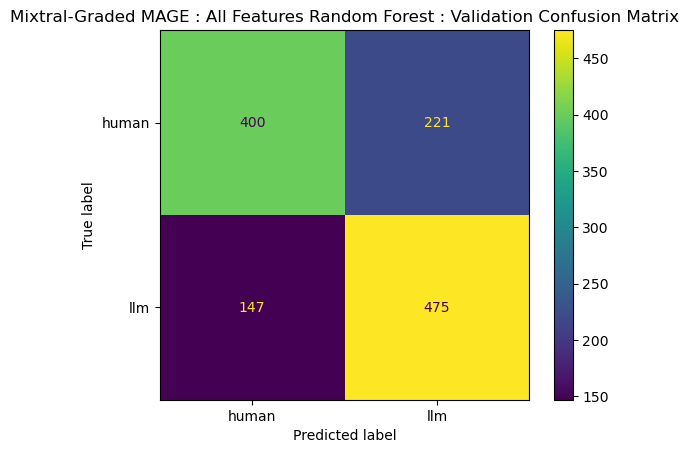

coif1_detail_kurt         0.037563
bior3.3_detail_entropy    0.034433
db2_detail_kurt           0.034255
db4_detail_entropy        0.033173
db4_detail_kurt           0.030352
sym4_detail_kurt          0.030179
db4_detailL1_ratio        0.030130
db8_wavelet_hf_ratio      0.029091
bior3.3_detail_kurt       0.027782
db2_detailL1_ratio        0.025521
coif1_detailL1_ratio      0.024874
db8_detailL4_ratio        0.024308
sym4_detailL1_ratio       0.023230
db2_wavelet_hf_ratio      0.022918
db8_detailL1_ratio        0.021413
db2_detail_entropy        0.021183
sym4_detail_entropy       0.021008
coif1_detail_entropy      0.020859
db2_detailL3_ratio        0.020761
sym4_detailL3_ratio       0.020263
dtype: float64

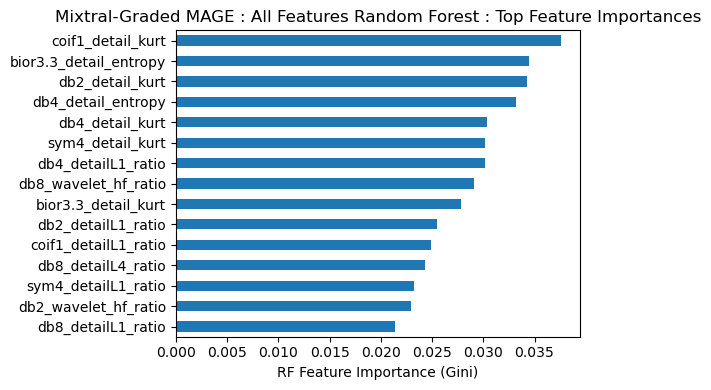

In [111]:
rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=all_features,
    title='Mixtral-Graded MAGE : All Features Random Forest'
)

## RESULTS (MAGE, Mixtral-Graded)
0.703 F1 score.  Not great.